# [Draft] Two-phase flow

In [1]:
from dune.grid import reader
from dune.mmesh import mmesh, trace, skeleton, domainMarker
from dune.fem.view import adaptiveLeafGridView as adaptive

dim = 2
file = "grids/circle.msh"

gridView = adaptive( mmesh((reader.gmsh, file), dim) )
hgrid = gridView.hierarchicalGrid
igridView = adaptive( hgrid.interfaceGrid )

In [2]:
from dune.ufl import Constant

nu0   = Constant(1e-2, name="nu0")
nu1   = Constant(1e-2, name="nu1")

rho0  = Constant(1, name="rho0")
rho1  = Constant(0.9, name="rho1")

grav  = [0, -9.81]
sigma = Constant(1e-2, name="sigma")

dt = 0.01
T  = 1.0

In [3]:
from dune.mmesh import domainMarker

dm = domainMarker(gridView)
nu  = (1-dm) * nu0  + dm * nu1
rho = (1-dm) * rho0 + dm * rho1

In [4]:
from ufl import *
from dune.fem.space import dglagrange, product

uspace = dglagrange(gridView, dimRange=2, order=2)
pspace = dglagrange(gridView, order=1)

u  = TrialFunction(uspace)
uu = TestFunction(uspace)

p  = TrialFunction(pspace)
pp = TestFunction(pspace)

uh  = uspace.interpolate([0,0], name="velocity")
uh1 = uspace.interpolate([0,0], name="velocity1")
ph  = pspace.interpolate(0, name="pressure")

## Curvature

In [5]:
from dune.fem.space import lagrange
from dune.fem.scheme import galerkin

kspace = lagrange(igridView, dimRange=dim, order=1)
k  = TrialFunction(kspace)
kk = TestFunction(kspace)

curvature = kspace.interpolate([0]*dim, name="curvature")

ix = SpatialCoordinate(kspace)
C  = inner(k, kk) * dx
C -= inner(grad(ix), grad(kk)) * dx
kscheme = galerkin([C == 0])

kscheme.solve(curvature)

{'converged': True, 'iterations': 1, 'linear_iterations': 1}

## Navier-Stokes equations

In [6]:
from dune.mmesh import interfaceIndicator, normals
from dune.fem.scheme import galerkin
from dune.ufl import Constant, DirichletBC

x = SpatialCoordinate(pspace)
n = FacetNormal(pspace)
I = interfaceIndicator(igridView)
n_I = normals(igridView)

uBC = as_vector([0, 0])

tau = Constant(dt, name="tau")
penu = Constant(1e6, name="penaltyu")
penp = Constant(1e6, name="penaltyp")

f  = rho * as_vector(grav)

# Chorin's method
a1  = rho * inner(u - uh, uu) / tau * dx
a1 += rho * inner(grad(uh) * uh, uu) * dx
a1 += nu * inner(grad(u), grad(uu)) * dx
a1 -= inner(f, uu) * dx
a1 += penu * inner(jump(u), jump(uu)) * dS
a1 += penu * inner(u - uBC, uu) * ds

a2  = inner(grad(p), grad(pp)) * dx
a2 += rho * div(uh1) * pp / tau * dx
a2 += penp * jump(p) * jump(pp) * dS
a2 -= jump(pp) * dot(avg(grad(p )), n('+')) * dS
a2 -= jump(p ) * dot(avg(grad(pp)), n('+')) * dS
a2 += 1e-3 * p * pp * dx

symG = nabla_grad(uh) + nabla_grad(uh).T
S = dot(n('+'), dot(jump(nu * symG), n('+')))
S += sigma * inner(avg(skeleton(curvature)), n('+'))
a2 -= penu * S * jump(pp) * I * dS
a2 += S * dot(avg(grad(pp)), n('+')) * dS


a3  = rho * inner(u - uh1, uu) * dx
a3 += tau * inner(grad(ph), uu) * dx
a3 += penu * inner(jump(u), jump(uu)) * dS
a3 += penu * inner(u - uBC, uu) * ds

A1 = galerkin([a1 == 0], solver=('suitesparse', 'umfpack'))
A2 = galerkin([a2 == 0], solver=('suitesparse', 'umfpack'))
A3 = galerkin([a3 == 0], solver=('suitesparse', 'umfpack'))

## Moving mesh

In [7]:
from dune.mmesh import edgeMovement
from dune.geometry import vertex
import numpy as np

trUh = trace(uh)
def getShifts():
    mapper = igridView.mapper({vertex: 1})
    shifts = np.zeros((mapper.size, dim))
    for e in igridView.elements:
        for v in e.subEntities(igridView.dimension):
            x = e.geometry.toLocal(v.geometry.center)
            shifts[ mapper.index(v) ] += 0.5 * trUh(e, x)
    return shifts

em = edgeMovement(gridView, getShifts())

## Timeloop

t = 0.000
t = 0.010
t = 0.020
t = 0.030
t = 0.040
t = 0.050
t = 0.060
t = 0.070
t = 0.080
t = 0.090
t = 0.100
t = 0.110


RuntimeError: GridError [ensureInterfaceMovement:/Users/samuelburbulla/dune/dune-mmesh/dune/mmesh/grid/mmesh.hh:811]: A cell has a negative volume! Maybe the interface has been moved too far?

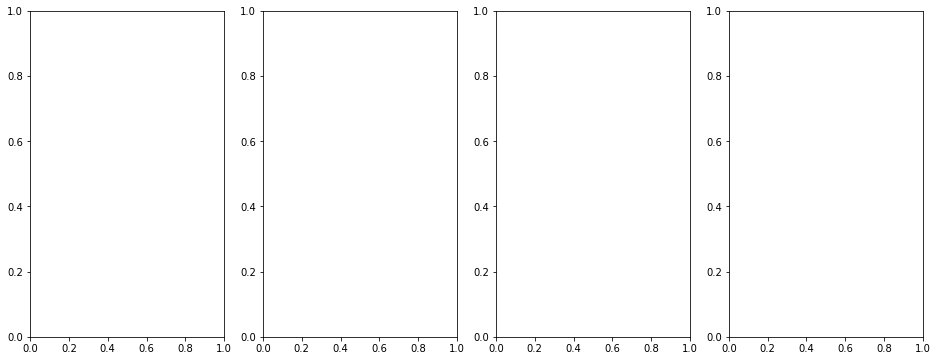

In [8]:
from dune.fem import parameter, adapt
parameter.append( { "fem.adaptation.method": "callback" } )
from dune.fem.plotting import plotPointData as plot
import matplotlib.pyplot as plt

N = 4
i = 0
fig, axs = plt.subplots(1, N, figsize=(16,6))

uh.interpolate([0,0])
ph.interpolate(0)

step = 0
t = 0
while t <= T:
    kscheme.solve(curvature)

    A1.solve(target=uh1)
    A2.solve(target=ph)
    A3.solve(target=uh)

    hgrid.markElements()
    hgrid.ensureInterfaceMovement( 10*dt*getShifts() )
    adapt([uh, dm])
    hgrid.moveInterface( dt*getShifts() )
    
    print("t =", "{:.3f}".format(t))
    t += dt
    
    gridView.writeVTK("twophase-"+str(step), pointdata=[ph, uh, uh1], celldata=[dm],
                      nonconforming=True)
    igridView.writeVTK("interface-"+str(step), pointdata=[curvature], nonconforming=True)
    step += 1
    

    if int(N * t/T) > i:
        plot(ph, figure=(fig, axs[i]), gridLines=None)
        plot(uh, figure=(fig, axs[i]), gridLines=None, vectors=[0,1])
        i += 1